# Exploratory analysis speakers aggregations

This notebook has a similar structure that Retrieve_metadata(ada-2021-project-adacadabra.gitSPEAKERS_METADATA/Retrieve_metadata.ipynb). 

However, it uses the results of classification step (extract quotations with colloquial langage) to perform an aggregation on speakers and apply an exploratory analysis. This notebook is the first iterative step in exploring the data on speakers aggregations. It does not consitutes any relevant statistical results and have to be considered only in a "exploratory way".

***Important remark:*** due to their large size, the samples of data have been retrieve in local. Therefore, if you do not have the sample, do not run the cells but only inspect the results of each cell that have been runned.

In [2]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(25,7)})

## 1. Import data


### Metadata

Pandas requires pyarrow to read parquet files, which can be installed using conda install pyarrow -c conda-forge.
You can load this file as a pandas dataframe using df = pd.read_parquet(<path_to_file>).

In [4]:
#Define the path for folder containing data
#TO BE MODIFIED ACCORDING HIS OWN FOLER containing data in local 
#Jules:
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'
df_metadata = pd.read_parquet(path+'speaker_attributes.parquet')
#df_metadata.head()

### Quotations dataset

In [5]:
#Import the dataset sample

#Jules: 
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'

df_sample = pd.read_json(path+'Sample_classified_1Mio_v1.json.bz2',compression = 'bz2',lines = True)


In [6]:
df_sample.sample(20)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,p1,p2,delta_p,year,colloquial
286311,2017-05-08-007599,Apple has proven its resilience through its un...,Brian White,"[Q21461106, Q3644521, Q4965621, Q4965623, Q574...",2017-05-08 11:09:00,5,"[[Brian White, 0.9387], [None, 0.0613]]",[http://www.philly.com/r?19=961&43=1585061&44=...,E,0.9387,0.0613,0.8774,2017,1
531228,2019-04-12-121990,whether feeding stingrays at the zoo or filmin...,Richard Ray,[Q7328608],2019-04-12 13:30:00,1,"[[Richard Ray, 0.8245], [None, 0.1755]]",[http://www.star-telegram.com/opinion/opn-colu...,E,0.8245,0.1755,0.6490,2019,1
363734,2018-07-26-045989,"If we had played Sunday, the players would hav...",Stephen Kenny,"[Q520167, Q7609675]",2018-07-26 05:00:00,1,"[[Stephen Kenny, 0.9411], [None, 0.0589]]",[https://www.irishmirror.ie/sport/stephen-kenn...,E,0.9411,0.0589,0.8822,2018,0
262418,2017-02-01-155602,We need to hold these people accountable and t...,David Simmons,"[Q20985769, Q21600957, Q27074142, Q51084835, Q...",2017-02-01 22:22:17,1,"[[David Simmons, 0.7523], [None, 0.2477]]",[http://wftv.com/news/local/new-bill-would-pos...,E,0.7523,0.2477,0.5046,2017,1
339643,2018-02-02-068183,It is clear that this pressure was taking its ...,Simon Taylor,"[Q15452415, Q16213289, Q2287843, Q53340356, Q5...",2018-02-02 00:00:00,90,"[[Simon Taylor, 0.8543], [None, 0.1457]]",[https://www.aol.co.uk/2018/02/02/father-at-hi...,E,0.8543,0.1457,0.7086,2018,0
660885,2020-02-12-076903,Shocked to hear about the untimely demise of W...,Smriti Irani,[Q7546539],2020-02-12 14:30:33,16,"[[Smriti Irani, 0.843], [None, 0.1021], [Wende...",[http://indiatoday.intoday.in/lifestyle/celebr...,E,0.8430,0.1021,0.7409,2020,1
48887,2015-02-03-022032,His life was like a novel.,Paul Williams,"[Q11339500, Q1375801, Q14948624, Q15441162, Q1...",2015-02-03 10:35:38,1,"[[Paul Williams, 0.6931], [None, 0.3069]]",[http://chorley-guardian.co.uk/news/local/wart...,E,0.6931,0.3069,0.3862,2015,0
277502,2017-07-07-009939,At times it was a bit like the old days going ...,Ian Williams,"[Q16189568, Q21104316, Q3147336, Q3147338, Q37...",2017-07-07 11:46:47,1,"[[Ian Williams, 0.9216], [None, 0.0733], [Chri...",[http://www.sailingscuttlebutt.com/2017/07/07/...,E,0.9216,0.0733,0.8483,2017,1
283873,2017-08-24-153954,"This is such an unprecedented event, such a sp...",Stephen Espinoza,[Q23772065],2017-08-24 08:21:50,2,"[[Stephen Espinoza, 0.9332], [None, 0.0518], [...",[https://ca.sports.yahoo.com/news/mayweather-m...,E,0.9332,0.0518,0.8814,2017,1
356887,2018-12-03-060736,"Minority ko aarakshan dene ka khel, yeh desh k...",Narendra Modi,[Q1058],2018-12-03 17:15:00,4,"[[Narendra Modi, 0.8344], [None, 0.1657]]",[http://wap.business-standard.com/article/elec...,E,0.8344,0.1657,0.6687,2018,1


### Lookup table for QIDs

#### Using the provided csv file to link qids with meaningful names

In [7]:
#read the file 
df_lookup = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2',index_col='QID')
#df_lookup.sample(20)

### 2. Merge speakers metadata with quotations 

Join quotations data with metadata :

In [133]:
#Create sub-sample
#df_sub = df_sample.sample(int(1*10e3))
df_sub = df_sample.copy()
s1 = len(df_sub)

#For the moment, choose rows which at minimum 1 qid associated
#Remove this row when using the data that have been wrangled
df_sub = df_sub[[len(a)>0 for a in df_sub['qids']]]

s2 = len(df_sub)

print('There is {} % of rows that have no qid associated with (on {} rows)'.format((1-s2/s1)*100,s1))

#Choose the first QID that is associated with (to be improved)
df_sub['qid_unique'] = df_sub['qids'].apply(lambda x: x[0]) 

There is 0.0 % of rows that have no qid associated with (on 668534 rows)


In [136]:
#Perform a group_by on quotations by speaker 
df_grouped = df_sub.groupby(['qid_unique', 'colloquial']).size().unstack(fill_value=0).reset_index()
df_grouped['quotes_number'] = df_grouped[1]+df_grouped[0]
df_grouped.sort_values(['quotes_number'], ascending=False) 

# Create also a column (called "fraction") that computes the fraction of colloquial quotes over total quotations. (by speaker)
df_grouped['fraction']=df_grouped[1]/(df_grouped['quotes_number'])
df_grouped.reset_index().sort_values(['fraction'], ascending=False)


colloquial,index,qid_unique,0,1,quotes_number,fraction
173959,173959,Q999889,0,1,1,1.0
104293,104293,Q4696730,0,1,1,1.0
31944,31944,Q1740079,0,1,1,1.0
104288,104288,Q4696700,0,1,1,1.0
31948,31948,Q1740086,0,1,1,1.0
...,...,...,...,...,...,...
102323,102323,Q45561071,1,0,1,0.0
102319,102319,Q45558354,1,0,1,0.0
32878,32878,Q17564389,1,0,1,0.0
32879,32879,Q17564409,1,0,1,0.0


In [135]:
#Merging with metadata

df_merged = df_grouped.merge(df_metadata,how='inner',left_on='qid_unique', right_on='id').sort_values(['quotes_number'], ascending=False)

In [137]:
#Replace label column at the first place to see speakers names

# shift column 'Name' to first position
first_column = df_merged.pop('label')
# insert column using insert(position,column_name,first_column) function
df_merged.insert(0, 'label', first_column)
df_merged.head(20)

,label,qid_unique,0,1,quotes_number,fraction,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion
102255,Barack Obama,Q76,1008,359,1367,0.262619,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]"
55163,Bernie Sanders,Q359442,723,268,991,0.270434,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],1392561607,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268]
62477,Francis,Q450675,641,271,912,0.297149,"[Jorge Mario Bergoglio, Francisco, Pope Franci...",[+1936-12-17T00:00:00Z],"[Q237, Q414]",[Q6581097],1396054797,[Q1056744],None,"[Q63173086, Q593644, Q104050302, Q36180, Q1234...",None,[Q1233889],Q450675,None,item,[Q9592]
90835,Hillary Clinton,Q6294,645,245,890,0.275281,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1393846565,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203]
2501,Andrew Cuomo,Q11673,476,182,658,0.276596,[Andrew Mark Cuomo],[+1957-12-06T00:00:00Z],[Q30],[Q6581097],1393197828,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841]
61464,Benjamin Netanyahu,Q43723,398,163,561,0.290553,"[Binyamin Netanyahu, Bibi, Bibi Netanyahu, Ben...",[+1949-10-21T00:00:00Z],[Q801],[Q6581097],1391756559,[Q7325],None,"[Q82955, Q193391, Q372436, Q47064, Q15958642, ...",[Q187009],"[Q787674, Q950900]",Q43723,"[Q2917048, Q2480394, Q2689039]",item,[Q9268]
61280,Elizabeth Warren,Q434706,378,179,557,0.321364,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1394365746,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203]
21074,Boris Johnson,Q180589,406,141,547,0.257770,"[Boris, Alexander Boris de Pfeffel Johnson, Bo...",[+1964-06-19T00:00:00Z],"[Q30, Q145]",[Q6581097],1395092363,[Q7994501],None,"[Q1930187, Q82955, Q1607826, Q36180, Q11774202...",[Q9626],None,Q180589,"[Q30173038, Q30325756, Q428598, Q590740, Q3586...",item,[Q6423963]
63367,Rodrigo Duterte,Q457786,316,230,546,0.421245,"[Rodrigo Roa Duterte, Rodrigo ""Rody"" Roa Duter...",[+1945-03-28T00:00:00Z],[Q928],[Q6581097],1348817804,[Q1290600],None,[Q82955],[Q7140531],None,Q457786,None,item,None
18627,Nancy Pelosi,Q170581,388,131,519,0.252408,"[Nancy Patricia D'Alesandro Pelosi, Nancy Patr...",[+1940-03-26T00:00:00Z],[Q30],[Q6581072],1392905094,[Q974693],P000197,[Q82955],[Q29552],None,Q170581,"[Q28404971, Q28122293, Q52494157]",item,[Q1841]


## 3. Exploratory analysis

In [139]:
col_subset = ['gender','nationality','occupation']
# data wrangling : remove NaNs, speakers that does not contains the specified metadata feature
df_plot = df_merged.copy()
df_plot.dropna(axis = 0, subset=col_subset,inplace=True)

for col in col_subset: 
    #For the moment, only taking the first item that is on the list
    df_plot[col]= df_plot[col].apply(lambda x:x[0])

- Distribution of colloquial quotes fraction: 

Text(0, 0.5, 'Number of speakers')

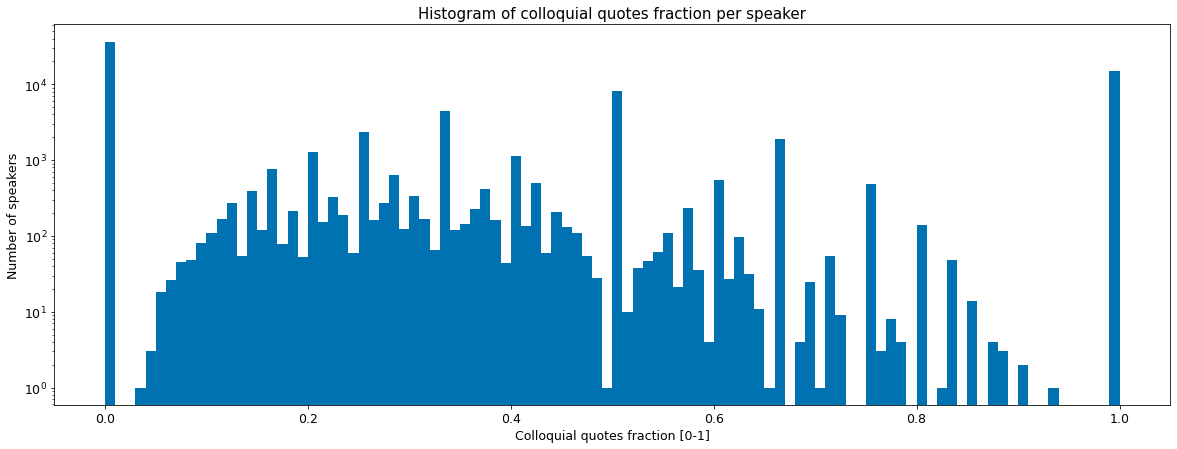

In [138]:
array_100 = plt.hist(df_plot['fraction'],bins=100,log=True)
plt.title('Histogram of colloquial quotes fraction per speaker')
plt.xlabel('Colloquial quotes fraction [0-1]')
plt.ylabel('Number of speakers')


It appears that a large number of speakers has a colloquial fraction equals to 0 or 1. These speakers probably correspond to the ones which have only 1 quote associated with. Therefore, their colloquial fraction could be only equals to 0 and 1.

For the next of the analysis, we will have to decide if we keep these speakers and treat them in a specific way or if we have simply to remove them.


- Fraction of colloquial language of 10 most represented speakers

[Text(0.5, 0, 'Speaker name'), Text(0, 0.5, 'Fraction of colloquial quotes')]

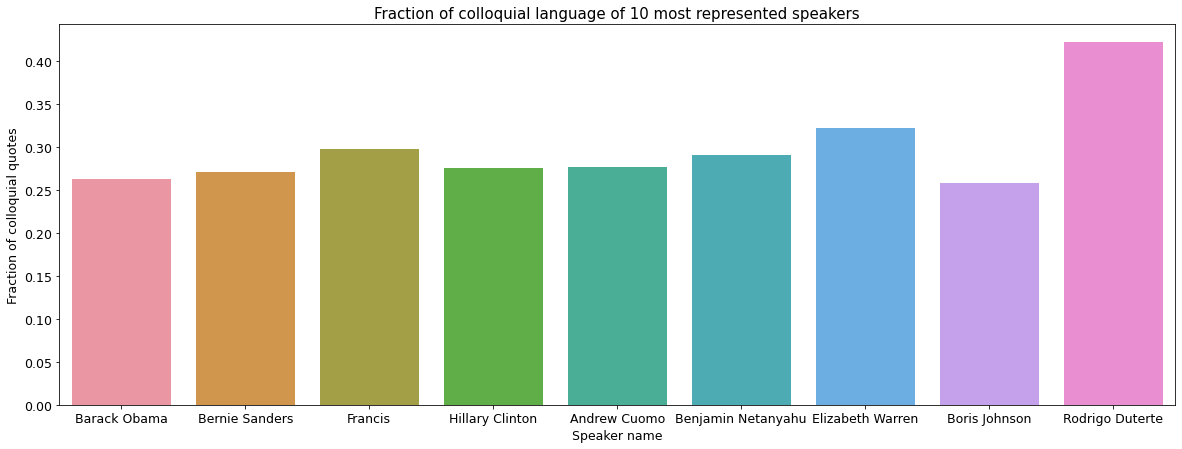

In [44]:
ax = sns.barplot(x="label", y="fraction",data=df_plot[:9])
ax.set_title('Fraction of colloquial language of 10 most represented speakers')
ax.set(xlabel='Speaker name',ylabel='Fraction of colloquial quotes')

- Fraction of colloquial langage by gender :  

[Text(0, 0.5, 'Average fraction of colloquial quotations')]

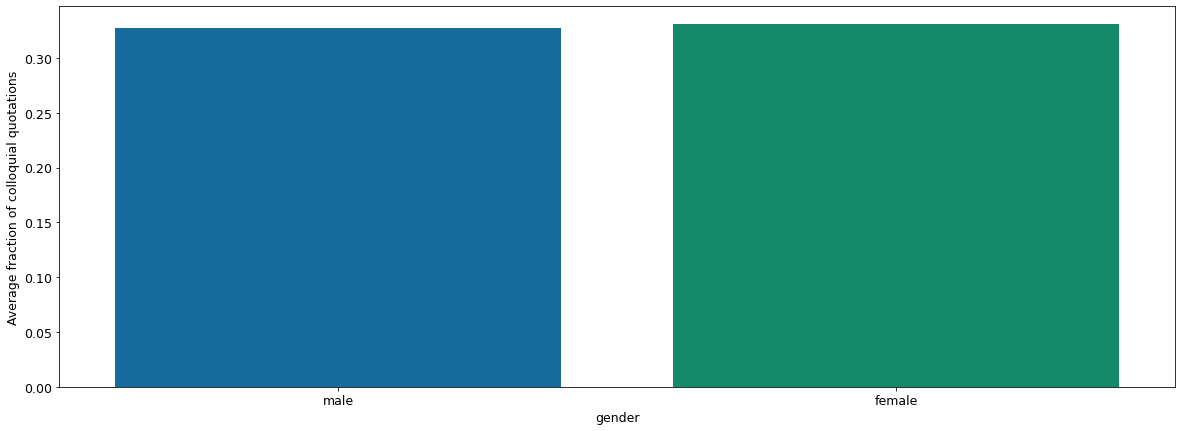

In [119]:
df_gender = df_plot.groupby('gender')['fraction'].mean() \
            .reset_index(name='mean_fraction')

df_gender['gender'] = df_gender['gender'].apply(lambda x: df_lookup.loc[x]['Label'])
df_gender = df_gender.set_index('gender')
df_mf = df_gender.loc[['male','female']].reset_index()

ax = sns.barplot(x='gender', y="mean_fraction", data=df_mf)
ax.set(ylabel='Average fraction of colloquial quotations')

[Text(0.5, 0, 'speaker_occupation'),
 Text(0, 0.5, 'Colloquial quotes fraction')]

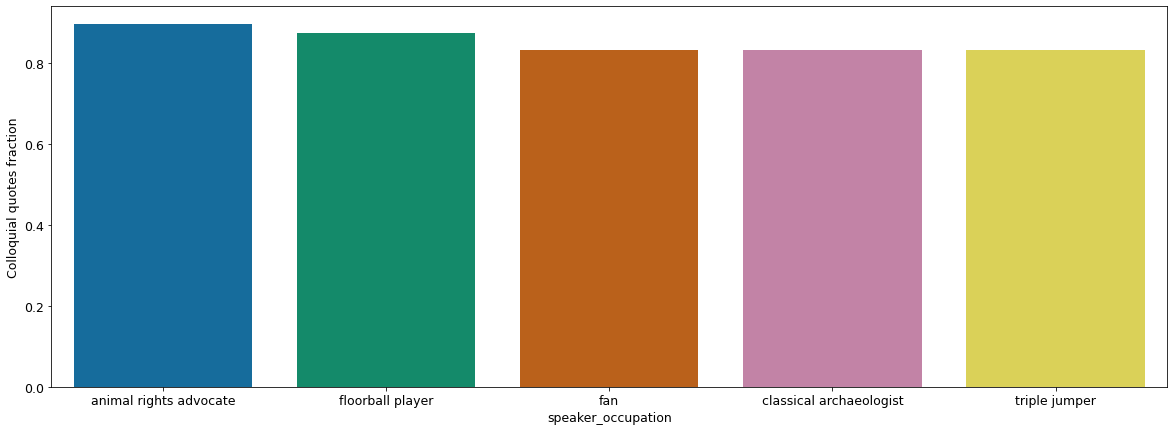

In [140]:
# fraction per occupation

df_occupation = df_plot.groupby('occupation')['fraction'].mean() \
                .reset_index(name='mean_fraction')\
                .sort_values(['mean_fraction'], ascending=False)

df_occupation['occupation'] = df_occupation['occupation'].apply(lambda x: df_lookup.loc[x]['Label'])

#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)

df_test = df_occupation[df_occupation['mean_fraction']!=1]

ax = sns.barplot(x="occupation", y="mean_fraction", data=df_test[:5])
ax.set(xlabel='speaker_occupation',ylabel='Colloquial quotes fraction')

##KEEP THIS PLOT ???

**Conclusion** : 
These results could not give meaningful interpretations. Therefore, the classification method has to be improved. The main problem that seems to arise is the too large size (20 000 entries) of the informal dictionary used for classification. Additionnaly, the speakers with a too low number of quotations has to be filtered as their aggregation could biased the result.